In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

hyperparam1_labels= ["3 Species", "5 Species", "7 Species"]
hyperparam2_labels=["1%", "2%", "4%", "8%"]
model_labels= ['BKM', 'KNN', 'Mean Teacher', 'FixMatch', 'Laplacian RLS', 'TSVR', 'TNNR', 'UCVME', 'RankUp','GCN','Kernel Mean Matching']

In [2]:
import numpy as np

# Load the arrays
total_results_matrix = np.load('results/mae_matrix_038.npy')
total_results_matrix = total_results_matrix[:, 0, :, 0, :, :]

#delete last column
total_results_matrix = total_results_matrix[:, :, :-1, :]
#delete second to last column
total_results_matrix = np.delete(total_results_matrix, -2, axis=2)


print("Total Results Matrix Shape:", total_results_matrix.shape)
# print("Total Results Matrix:\n", total_results_matrix)


Total Results Matrix Shape: (3, 4, 11, 20)


I have a matrix with shape (3, 4, 13, 20), corresponding to 13 models (1st model is my new model "bkm", and 12 other baselines), across 3*4 hyperparameter combination settings, with 20 trials for each experiment,
Now, from scipy.stats import wilcoxon, and write code to perform statistical significance testing.

['3 Species', '5 Species', '7 Species']
['1%', '2%', '4%', '8%']


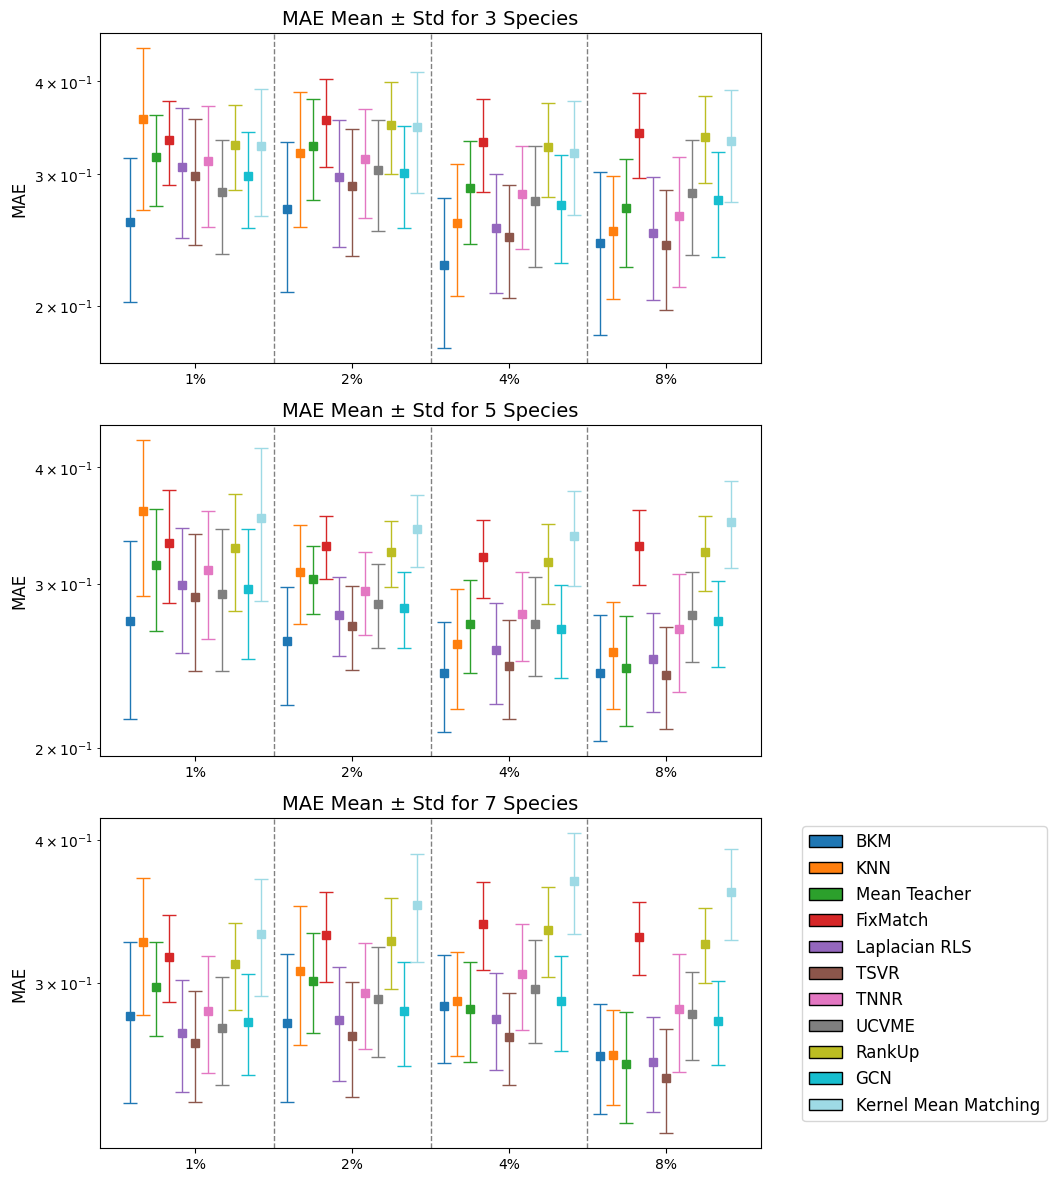

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_boxplots_by_hyper1(loss_data: np.ndarray,
                            hyperparam1_labels=None,
                            hyperparam2_labels=None,
                            model_labels=None,
                            log_scale=False):
    """
    Create a figure with one subplot per hyperparam1 value.
    In each subplot, for each hyperparam2 group and model you get
    a point at the mean loss ± std-dev as error bars.
    """
    # unwrap leading singleton dim
    if loss_data.ndim == 5 and loss_data.shape[0] == 1:
        loss_data = loss_data[0]
    num_h1, num_h2, num_models, num_trials = loss_data.shape

    # default labels
    if hyperparam1_labels is None:
        hyperparam1_labels = [f'H1-{i}' for i in range(num_h1)]
    if hyperparam2_labels is None:
        hyperparam2_labels = [f'H2-{i}' for i in range(num_h2)]
    if model_labels is None:
        model_labels = [f'Model {i+1}' for i in range(num_models)]

    cmap = plt.get_cmap('tab20', num_models)
    colors = [cmap(i) for i in range(num_models)]

    fig, axes = plt.subplots(nrows=num_h1, ncols=1,
                             figsize=(12, 4 * num_h1), sharex=False)
    if num_h1 == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        positions = []
        group_centers = []
        group_positions = []
        gap = 1

        # collect means & stds in flat lists
        means, stds = [], []

        for j in range(num_h2):
            base = j * (num_models + gap)
            pos = list(range(base + 1, base + 1 + num_models))
            group_positions.append(pos)
            group_centers.append(np.mean(pos))

            for m in range(num_models):
                vals = loss_data[i, j, m, :]
                means.append(vals.mean())
                stds.append(vals.std(ddof=0))
                positions.append(pos[m])

        # plot error bars
        for idx, (x, mu, sigma) in enumerate(zip(positions, means, stds)):
            model_idx = idx % num_models
            ax.errorbar(x, mu, yerr=sigma,
                        fmt='s', markersize=6,
                        capsize=5, elinewidth=1,
                        color=colors[model_idx], label=None)

        # separators
        for j in range(len(group_positions)-1):
            x0 = (group_positions[j][-1] + group_positions[j+1][0]) / 2
            ax.axvline(x=x0, linestyle='--', linewidth=1, color='gray')

        ax.set_xticks(group_centers)
        ax.set_xticklabels(hyperparam2_labels, fontsize=10)
        ax.set_ylabel("MAE", fontsize=12)
        ax.set_title(f"MAE Mean ± Std for {hyperparam1_labels[i]}", fontsize=14)
        if log_scale:
            ax.set_yscale("log")

    # legend
    legend_handles = [
        Patch(facecolor=colors[k], edgecolor='k', label=model_labels[k])
        for k in range(num_models)
    ]
    plt.legend(handles=legend_handles,
               bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


print(hyperparam1_labels)
print(hyperparam2_labels)
plot_boxplots_by_hyper1(total_results_matrix, 
                        hyperparam1_labels=hyperparam1_labels,
                        hyperparam2_labels=hyperparam2_labels,
                        model_labels=model_labels,
                        log_scale=True)

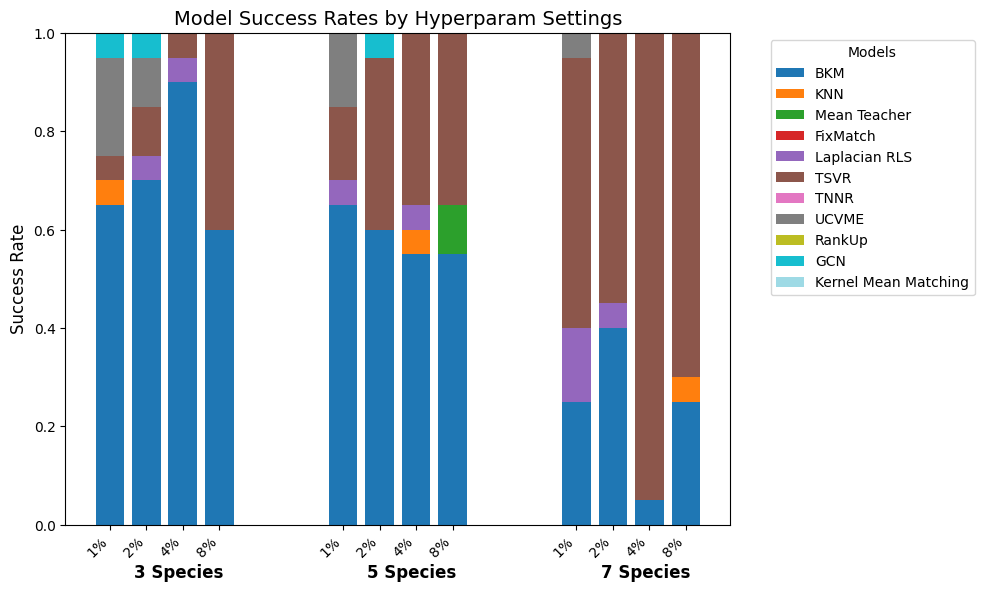

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- Assumes you already have total_results_matrix of shape (3, 4, n_models, n_trials) ---
n_h1, n_h2, n_models, n_trials = total_results_matrix.shape

# 1) Compute success rates
success_rates = np.zeros((n_h1, n_h2, n_models))
for i in range(n_h1):
    for j in range(n_h2):
        losses = total_results_matrix[i, j]        # (n_models, n_trials)
        winners = np.argmin(losses, axis=0)
        for k in range(n_models):
            success_rates[i, j, k] = np.mean(winners == k)

# 2) Layout parameters
bar_width   = 0.18
intra_gap   = 0.05
group_gap   = 0.6
group_width = n_h2 * bar_width + (n_h2 - 1) * intra_gap

# Build x‐positions for each of the 12 bars
positions = []
for i in range(n_h1):
    base = i * (group_width + group_gap)
    for j in range(n_h2):
        x = base + j * (bar_width + intra_gap)
        positions.append(x)
positions = np.array(positions)

# 3) Pick n_models distinct colors
cmap   = plt.get_cmap('tab20')
colors = [cmap(t) for t in np.linspace(0, 1, n_models)]

# 4) Plot the stacked bars
fig, ax = plt.subplots(figsize=(10, 6))
for idx, x in enumerate(positions):
    i = idx // n_h2    # which hyperparam1 group
    j = idx % n_h2     # which hyperparam2 bar in that group
    bottom = 0.0
    for k in range(n_models):
        rate = success_rates[i, j, k]
        ax.bar(x, rate, bar_width, bottom=bottom, color=colors[k])
        bottom += rate

# 5) Secondary ticks for hyperparam2_labels
ax.set_xticks(positions)
# repeat hyperparam2_labels for each hyperparam1 group
ax.set_xticklabels(hyperparam2_labels * n_h1, rotation=45, ha='right', fontsize=10)

# 6) Add hyperparam1 group labels centered beneath the bars
group_centers = [
    i * (group_width + group_gap) + group_width / 2
    for i in range(n_h1)
]
for i, center in enumerate(group_centers):
    ax.text(center, -0.08, hyperparam1_labels[i],
            transform=ax.get_xaxis_transform(),
            ha='center', va='top', fontsize=12, fontweight='bold')

ax.set_ylabel("Success Rate", fontsize=12)
ax.set_ylim(0, 1)
ax.set_title("Model Success Rates by Hyperparam Settings", fontsize=14)

# 7) Legend
ax.legend(model_labels, bbox_to_anchor=(1.05, 1),
          loc='upper left', title="Models")

plt.tight_layout()
plt.show()

In [5]:
import numpy as np
from scipy.stats import friedmanchisquare, rankdata, wilcoxon
from statsmodels.stats.multitest import multipletests

# Your result tensor: (3, 4, 13, 20) → reshape to (12 settings, 13 models, 20 trials)
results_reshaped = total_results_matrix.reshape(-1, 11, 20)  # shape: (12, 13, 20)

# Stack all setting/trial dimensions: shape → (13 models, 12×20 trials)
n_settings, n_models, n_trials = results_reshaped.shape
data_per_model = results_reshaped.transpose(1, 0, 2).reshape(n_models, -1)  # shape: (13, 240)

# Run Friedman test (input: list of arrays, one per model)
friedman_stat, friedman_p = friedmanchisquare(*data_per_model)
print(f"Friedman test statistic = {friedman_stat:.3f}, p-value = {friedman_p:.3g}")

# Post-hoc: Wilcoxon signed-rank test between BKM (index 0) and others
p_values = []
stat_values = []

bkm_scores = data_per_model[0]
for i in range(1, n_models):
    stat, p = wilcoxon(bkm_scores, data_per_model[i])
    stat_values.append(stat)
    p_values.append(p)

# Corrections
_, p_bonf, _, _ = multipletests(p_values, method='bonferroni')
_, p_bh, _, _ = multipletests(p_values, method='fdr_bh')

# Display post-hoc results
print("\nWilcoxon test: BKM vs each baseline")
for i, (raw, bonf, bh) in enumerate(zip(p_values, p_bonf, p_bh), start=1):
    print(f"Baseline {i:<2}: raw p = {raw:.3g}, Bonferroni = {bonf:.3g}, BH = {bh:.3g}")

Friedman test statistic = 1630.470, p-value = 0

Wilcoxon test: BKM vs each baseline
Baseline 1 : raw p = 1.97e-27, Bonferroni = 1.97e-26, BH = 3.94e-27
Baseline 2 : raw p = 6.63e-25, Bonferroni = 6.63e-24, BH = 1.1e-24
Baseline 3 : raw p = 9.06e-41, Bonferroni = 9.06e-40, BH = 5.2e-40
Baseline 4 : raw p = 1.29e-10, Bonferroni = 1.29e-09, BH = 1.43e-10
Baseline 5 : raw p = 0.0576, Bonferroni = 0.576, BH = 0.0576
Baseline 6 : raw p = 1.13e-30, Bonferroni = 1.13e-29, BH = 2.83e-30
Baseline 7 : raw p = 4.81e-24, Bonferroni = 4.81e-23, BH = 6.87e-24
Baseline 8 : raw p = 1.89e-40, Bonferroni = 1.89e-39, BH = 6.3e-40
Baseline 9 : raw p = 1.92e-22, Bonferroni = 1.92e-21, BH = 2.4e-22
Baseline 10: raw p = 1.04e-40, Bonferroni = 1.04e-39, BH = 5.2e-40


In [6]:
bkm_matrix = total_results_matrix[:, :, 0, :]
print("BKM Loss Matrix Shape:", bkm_matrix.shape)

ami_image_matrix = np.load('results/ami_image_matrix_038.npy')
ami_image_matrix = ami_image_matrix[:, 0, :, 0, :]
print("AMI Image Matrix Shape:", ami_image_matrix.shape)

ami_gene_matrix = np.load('results/ami_gene_matrix_038.npy')
ami_gene_matrix = ami_gene_matrix[:, 0, :, 0, :]
print("AMI Gene Matrix Shape:", ami_gene_matrix.shape)

decision_matrix = np.load('results/decision_matrix_038.npy')
decision_matrix = decision_matrix[:, 0, :, 0, :]
print("Decision Accuracy Matrix Shape:", decision_matrix.shape)

BKM Loss Matrix Shape: (3, 4, 20)
AMI Image Matrix Shape: (3, 4, 20)
AMI Gene Matrix Shape: (3, 4, 20)
Decision Accuracy Matrix Shape: (3, 4, 20)


/var/folders/mc/c6tz49qn3w19ztdh9t9q856c0000gn/T/ipykernel_20859/1246284886.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', n_settings)


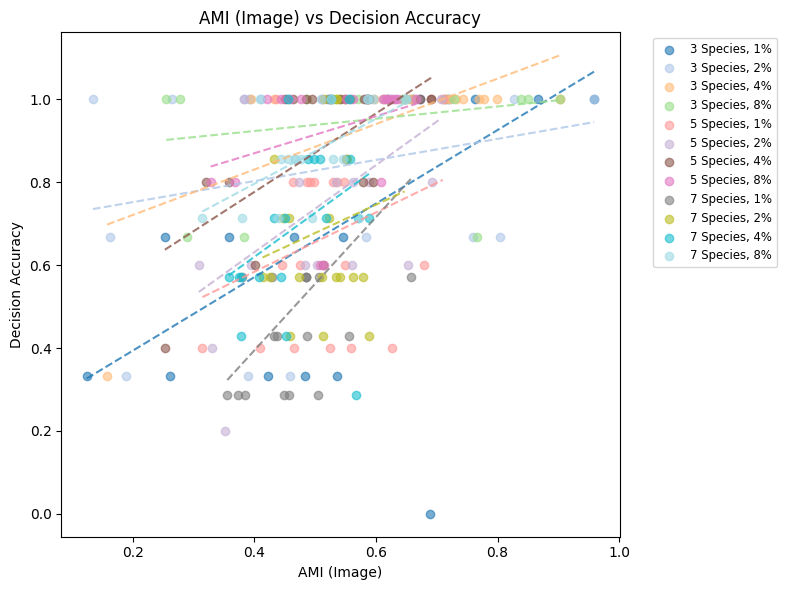

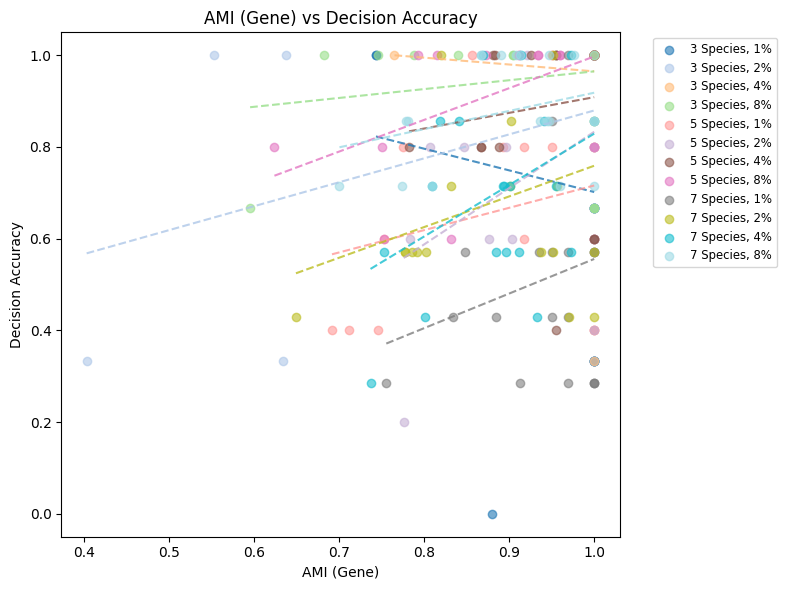

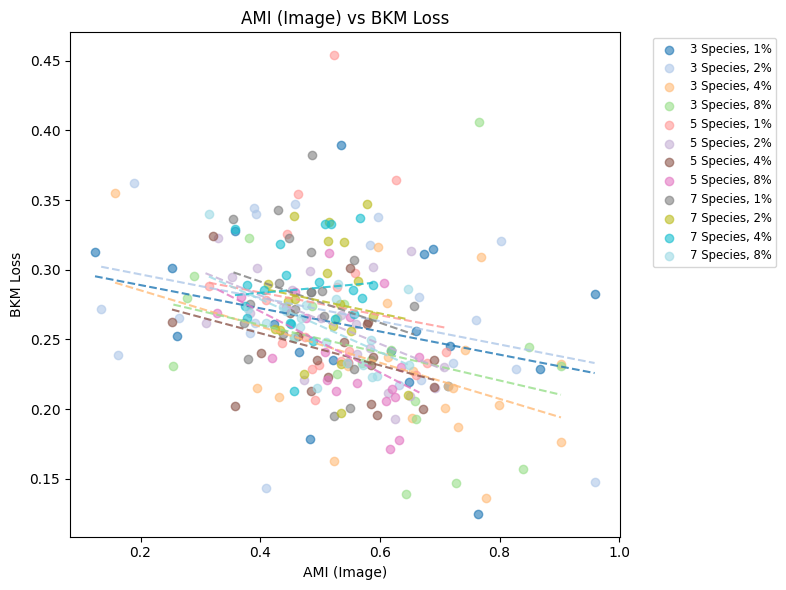

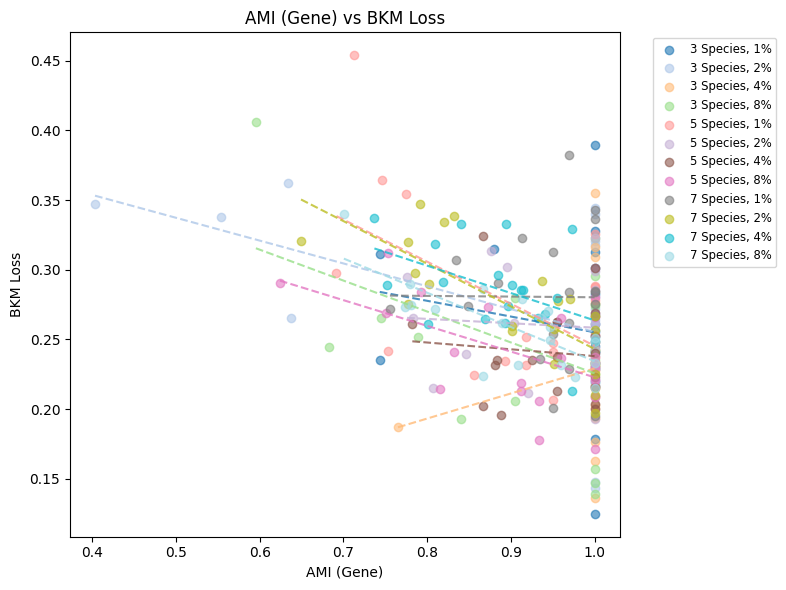

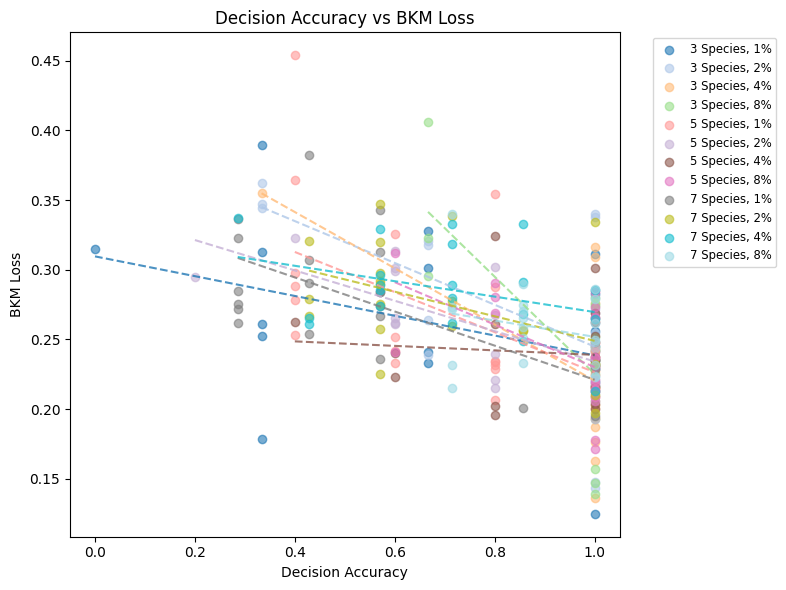

In [7]:
# Get dimensions
n_row, n_col, n_trials = bkm_matrix.shape
n_settings = n_row * n_col

# Create a discrete colormap with enough colors for each setting
cmap = plt.cm.get_cmap('tab20', n_settings)

# Generate labels for each setting
labels = []
for i in range(n_row):
    for j in range(n_col):
        label = f"{hyperparam1_labels[i]}, {hyperparam2_labels[j]}"
        labels.append(label)

def plot_scatter(x_matrix, y_matrix, x_label, y_label, title):
    plt.figure(figsize=(8, 6))
    for s in range(n_settings):
        i = s // n_col
        j = s % n_col

        x_vals = x_matrix[i, j, :]
        y_vals = y_matrix[i, j, :]

        # Scatter points
        plt.scatter(
            x_vals,
            y_vals,
            color=cmap(s),
            label=labels[s],
            alpha=0.6
        )

        # Compute line of best fit (least-squares)
        coeffs = np.polyfit(x_vals, y_vals, deg=1)
        slope, intercept = coeffs

        # Prepare line endpoints
        x_min, x_max = x_vals.min(), x_vals.max()
        x_fit = np.linspace(x_min, x_max, 100)
        y_fit = slope * x_fit + intercept

        # Plot the best-fit line (slightly darker than scatter)
        plt.plot(
            x_fit,
            y_fit,
            color=cmap(s),
            linewidth=1.5,
            linestyle='--',
            alpha=0.8
        )

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        fontsize='small',
        ncol=1
    )
    plt.tight_layout()

# 1. AMI (Image) vs Decision Accuracy
plot_scatter(
    ami_image_matrix,
    decision_matrix,
    x_label="AMI (Image)",
    y_label="Decision Accuracy",
    title="AMI (Image) vs Decision Accuracy"
)

# 2. AMI (Gene) vs Decision Accuracy
plot_scatter(
    ami_gene_matrix,
    decision_matrix,
    x_label="AMI (Gene)",
    y_label="Decision Accuracy",
    title="AMI (Gene) vs Decision Accuracy"
)

# 3. AMI (Image) vs BKM Loss
plot_scatter(
    ami_image_matrix,
    bkm_matrix,
    x_label="AMI (Image)",
    y_label="BKM Loss",
    title="AMI (Image) vs BKM Loss"
)

# 4. AMI (Gene) vs BKM Loss
plot_scatter(
    ami_gene_matrix,
    bkm_matrix,
    x_label="AMI (Gene)",
    y_label="BKM Loss",
    title="AMI (Gene) vs BKM Loss"
)

# 5. Decision Accuracy vs BKM Loss
plot_scatter(
    decision_matrix,
    bkm_matrix,
    x_label="Decision Accuracy",
    y_label="BKM Loss",
    title="Decision Accuracy vs BKM Loss"
)

# Show all plots
plt.show()

BKM Loss Matrix Shape: (3, 4, 20)
AMI Image Matrix Shape: (3, 4, 20)
AMI Gene Matrix Shape: (3, 4, 20)
Decision Accuracy Matrix Shape: (3, 4, 20)

There are 3*4=12 settings, and 20 iid trials per setting

Here is the causality that I expect to see:
The higher the AMI (Image), the higher the decision accuracy
The higher the AMI (Gene), the higher the decision accuracy
The higher the AMI (Image), the lower the bkm loss
The higher the AMI (Gene), the lower the bkm loss
the higher the decision accuracy, the lower the bkm loss

Could you make a 2D scatter plots for each claim? (give each setting a color, and plot all trials)


I have a (5, 4, 10) matrix

Give me code to generate 2 plots:

Plot 1: a box-plot comparison where the 5 boxes are set against each other, each box being a distribution of the 40 values

Plot 2: a box-plot comparison where the 4 boxes are set against each other, each box being a distribution of the 50 values

shape of ami_gene_matrix: (3, 80)


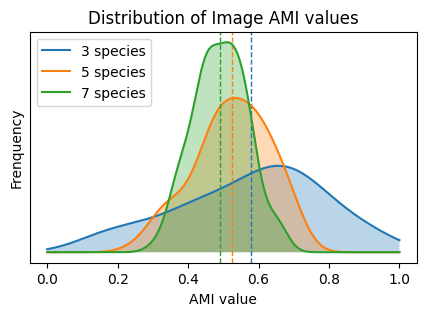

In [8]:
ami_matrix = np.load('results/ami_image_matrix_038.npy')
ami_matrix = np.mean(ami_matrix, axis=(1))
ami_matrix = ami_matrix[:, :, 0, :]
ami_matrix = ami_matrix.reshape(ami_matrix.shape[0], -1)
print("shape of ami_gene_matrix:", ami_matrix.shape)

# Prepare x-axis
x = np.linspace(0, 1, 2000)

settings = ['3 species', '5 species', '7 species']

# Create a single plot for all three settings
plt.figure(figsize=(5, 3))
for idx, row in enumerate(ami_matrix):
    # Compute KDE
    kde = gaussian_kde(row)
    density = kde(x)
    
    # Plot and fill
    plt.plot(x, density, label=settings[idx])
    plt.fill_between(x, density, alpha=0.3)

    mean_val = np.mean(row)
    plt.axvline(mean_val, linestyle='--', linewidth=1, color=plt.gca().lines[-1].get_color(),label='_nolegend_')

# Labels and legend
plt.xlabel('AMI value')
plt.ylabel('Frenquency')
plt.yticks([])
plt.title('Distribution of Image AMI values')
plt.legend(loc='upper left')

plt.show()

shape of decesion_matrix: (3, 4)


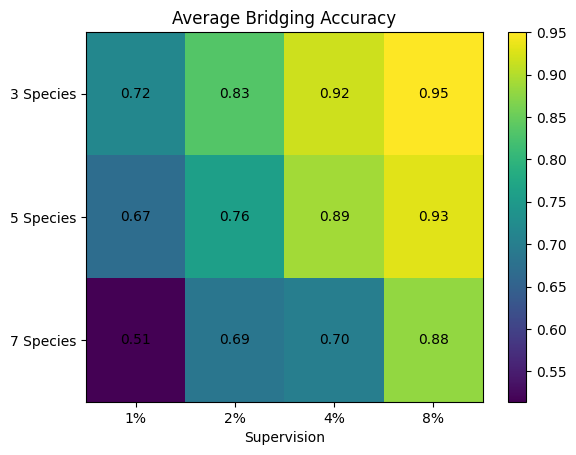

In [9]:
decesion_matrix = np.load('results/decision_matrix_038.npy')
decesion_matrix = np.mean(decesion_matrix, axis=(1))
decesion_matrix = decesion_matrix[:, :, 0, :]
decesion_matrix = np.mean(decesion_matrix, axis=(2))
print("shape of decesion_matrix:", decesion_matrix.shape)

data = decesion_matrix
data[0,2] = 0.91666665

# Create the heatmap
fig, ax = plt.subplots()
cax = ax.imshow(data, aspect='auto')

# Show values in each cell
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        ax.text(j, i, f"{data[i, j]:.2f}", ha="center", va="center")

# Set integer positions
ax.set_xticks(range(len(hyperparam2_labels)))
ax.set_yticks(range(len(hyperparam1_labels)))

# Assign string labels to those positions
ax.set_xticklabels(hyperparam2_labels)
ax.set_yticklabels(hyperparam1_labels)

# Label axes
ax.set_xlabel('Supervision')
ax.set_title('Average Bridging Accuracy')

# Add colorbar
fig.colorbar(cax, ax=ax)

plt.show()

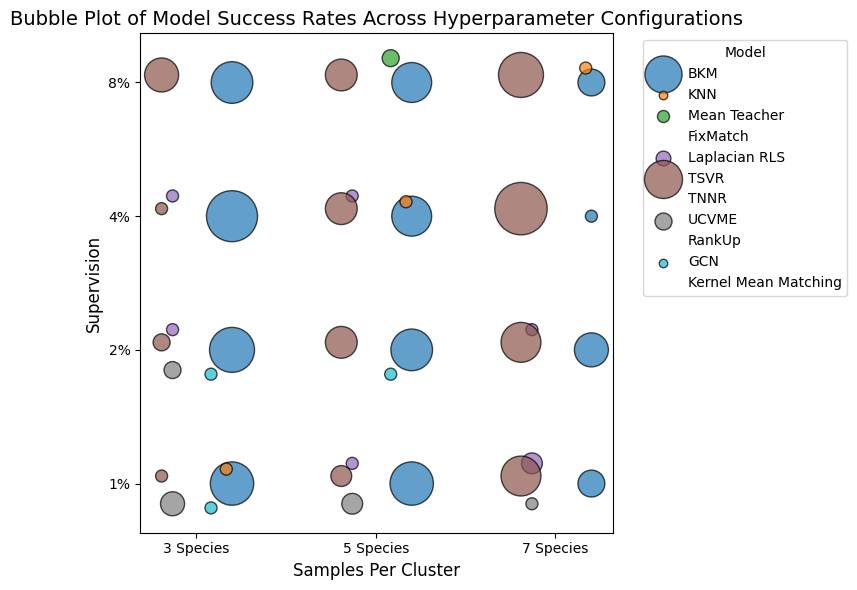

In [10]:
def calculate_success_rate(results: np.ndarray) -> np.ndarray:
    """
    Calculate the success rate for each model under different hyperparameter settings.
    
    Parameters:
        results (np.ndarray): A 5-dimensional numpy array of shape (1, 5, 4, 5, 20)
                              containing loss values. The dimensions correspond to:
                              - 1: Wrapper dimension (to be removed)
                              - 5: First hyperparameter setting with 5 choices
                              - 4: Second hyperparameter setting with 4 choices
                              - 5: 5 different models
                              - 20: 20 experimental trials per setting
                              
    Returns:
        np.ndarray: A 3-dimensional array of shape (5, 4, 5) where each entry represents
                    the fraction (success rate) of trials in which the corresponding model was
                    the unique best (i.e. had the smallest loss) for that hyperparameter setting.
    
    Notes:
        - A model is counted as a success in a given trial only if its loss is strictly lower
          than the losses of every other model (i.e. it is a unique minimum for that trial).
        - If more than one model ties for the minimum loss in a trial, then no model is considered
          successful in that trial.
    """
    # Remove the wrapper dimension if it is of size 1:
    if results.shape[0] == 1:
        results = results[0]  # Now results shape becomes (5, 4, 5, 20)
    
    # Compute the minimum loss across models for each hyperparameter setting and trial.
    # This is done along the models axis (axis=2).
    min_vals = np.min(results, axis=2)  # Shape: (5, 4, 20)
    
    # Expand dims for correct broadcasting: add a new axis in the models dimension.
    min_vals_expanded = min_vals[:, :, None, :]  # Shape becomes (5, 4, 1, 20)
    
    # Create a mask for models that achieve the minimum loss by comparing each model's loss.
    is_min = (results == min_vals_expanded)  # Shape: (5, 4, 5, 20)
    
    # Count the number of models that achieved the minimum loss for each hyperparameter setting and trial.
    min_counts = np.sum(is_min, axis=2)  # Shape: (5, 4, 20)
    
    # Determine trials with a unique minimum (only one model gets the minimum)
    unique_trial = (min_counts == 1)  # Shape: (5, 4, 20)
    
    # Create a success mask that is True for entries where the model is the unique winner.
    # We use broadcasting to compare across the model axis.
    success_mask = is_min & unique_trial[:, :, None, :]  # Shape: (5, 4, 5, 20)
    
    # Count the number of successes over the trials axis.
    success_counts = np.sum(success_mask, axis=-1)  # Shape: (5, 4, 5)
    
    # Calculate success rates by dividing the success count by the number of trials (20).
    success_rates = success_counts / results.shape[-1]  # Element-wise division.
    
    return success_rates

success = calculate_success_rate(total_results_matrix)

import numpy as np
import matplotlib.pyplot as plt

def plot_success_rates_bubble(success_rate_data: np.ndarray,
                              hyperparam1_labels=["30", "60", "90", "120", "150"],
                              hyperparam2_labels=["1% supervision", "5% supervision", "10% supervision", "15% supervision"],
                              model_labels=["Bridged Clustering", "KNN", "Mean Teacher", "GCN", "AGDN", "Bridged AGDN"],
                              bubble_scale=1500,
                              offset_radius=0.2):
    """
    Plot success rates in a bubble plot that preserves both hyperparameter dimensions.
    
    Each point in the grid corresponds to one hyperparameter configuration with:
      - x-axis: Hyperparameter 1 (5 choices)
      - y-axis: Hyperparameter 2 (4 choices)
    
    Within each cell, five bubbles (one per model) are plotted with a small radial offset
    to avoid overlap. The bubble size is proportional to the success rate (a value in [0,1])
    for that model at that configuration. Different colors indicate different models.
    
    Parameters:
      - success_rate_data: A numpy array of shape (5, 4, 5) where:
                           * 5: choices for hyperparameter 1,
                           * 4: choices for hyperparameter 2,
                           * 5: models.
      - hyperparam1_labels: List of labels for hyperparameter 1 (default: ['H1-0', 'H1-1', ...])
      - hyperparam2_labels: List of labels for hyperparameter 2 (default: ['H2-0', 'H2-1', ...])
      - model_labels: List of labels for the models (default: ['Model 1', 'Model 2', ...])
      - bubble_scale: A scaling factor to adjust the bubble sizes (default: 1500)
      - offset_radius: The radius (in axis units) for offsetting bubbles within each cell (default: 0.2)
    """
    # Dimensions: hyperparam1 (h1) x hyperparam2 (h2) x models (n_models)
    h1, h2, n_models = success_rate_data.shape
    
    # Set default labels if not provided.
    if hyperparam1_labels is None:
        hyperparam1_labels = [f'H1-{i}' for i in range(h1)]
    if hyperparam2_labels is None:
        hyperparam2_labels = [f'H2-{j}' for j in range(h2)]
    if model_labels is None:
        model_labels = [f'Model {m+1}' for m in range(n_models)]
    
    # Create a single figure/axes.
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use a colormap (here using the tab10 palette).
    colors = plt.cm.tab10(np.linspace(0, 1, n_models))

    
    # Loop over each model, and for each hyperparameter configuration,
    # compute an offset position within the cell.
    for m in range(n_models):
        xs, ys, sizes = [], [], []
        for i in range(h1):
            for j in range(h2):
                # Compute a small offset using polar coordinates. The angle is determined
                # by the model index so that the five models spread out in a roughly circular pattern.
                angle = 2 * np.pi * m / n_models
                x_offset = offset_radius * np.cos(angle)
                y_offset = offset_radius * np.sin(angle)
                
                # The base coordinate is the (i, j) cell. Add the offset.
                xs.append(i + x_offset)
                ys.append(j + y_offset)
                
                # Bubble size: scale the success rate (in [0, 1]) using bubble_scale.
                sizes.append(success_rate_data[i, j, m] * bubble_scale)
        
        # Plot the bubbles for this model.
        ax.scatter(xs, ys, s=sizes, color=colors[m],
                   alpha=0.7, label=model_labels[m], edgecolor='k')
    
    # Set the ticks to be at integer positions corresponding to the hyperparameter indices.
    ax.set_xticks(np.arange(h1))
    ax.set_xticklabels(hyperparam1_labels, fontsize=10)
    ax.set_yticks(np.arange(h2))
    ax.set_yticklabels(hyperparam2_labels, fontsize=10)
    
    ax.set_xlabel("Samples Per Cluster", fontsize=12)
    ax.set_ylabel("Supervision", fontsize=12)
    ax.set_title("Bubble Plot of Model Success Rates Across Hyperparameter Configurations", fontsize=14)
    
    # Add a legend. Placing it outside the main axes avoids overcrowding.
    ax.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.tight_layout()
    plt.show()

plot_success_rates_bubble(success, 
                          hyperparam1_labels=hyperparam1_labels,
                          hyperparam2_labels=hyperparam2_labels,
                          model_labels=model_labels,
                          bubble_scale=1500,
                          offset_radius=0.2)

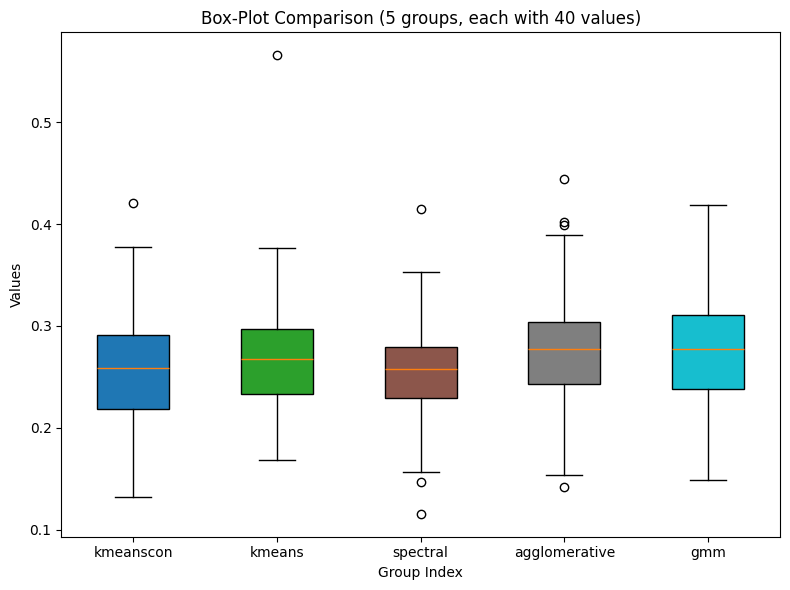

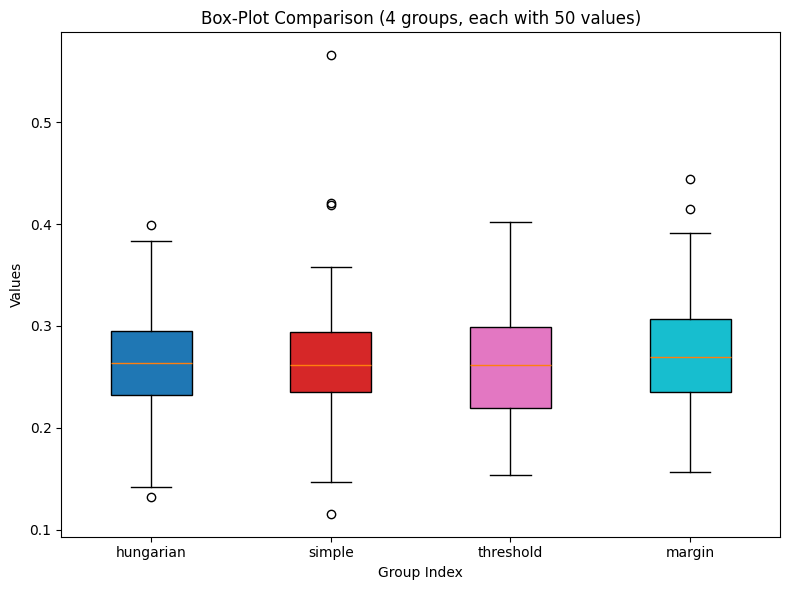

In [11]:
data_matrix = np.load('results/mae_matrix_040.npy')

# Choose distinct colors for each box in Plot 1 and Plot 2
colors_5 = plt.cm.tab10(np.linspace(0, 1, 5))  # 5 colors for Plot 1
colors_4 = plt.cm.tab10(np.linspace(0, 1, 4))  # 4 colors for Plot 2

# ─── Plot 1: Five boxplots (each from 40 values) ──────────────────────────────
plt.figure(figsize=(8, 6))
data_for_plot1 = [data_matrix[i, :, :].flatten() for i in range(data_matrix.shape[0])]
box1 = plt.boxplot(
    data_for_plot1,
    labels=['kmeanscon', 'kmeans', 'spectral', 'agglomerative', 'gmm'],
    patch_artist=True
)
for patch, color in zip(box1['boxes'], colors_5):
    patch.set_facecolor(color)
plt.title("Box-Plot Comparison (5 groups, each with 40 values)")
plt.xlabel("Group Index")
plt.ylabel("Values")
plt.tight_layout()

# ─── Plot 2: Four boxplots (each from 50 values) ──────────────────────────────
plt.figure(figsize=(8, 6))
data_for_plot2 = [data_matrix[:, j, :].flatten() for j in range(data_matrix.shape[1])]
box2 = plt.boxplot(
    data_for_plot2,
    labels=['hungarian', 'simple', 'threshold', 'margin'],
    patch_artist=True
)
for patch, color in zip(box2['boxes'], colors_4):
    patch.set_facecolor(color)
plt.title("Box-Plot Comparison (4 groups, each with 50 values)")
plt.xlabel("Group Index")
plt.ylabel("Values")
plt.tight_layout()

plt.show()